<a href="https://colab.research.google.com/github/kirbyju/TCIA_Notebooks/blob/main/TCIA_with_ITK_and_itkWidgets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
Access to large, high quality data is essential for researchers to understand disease and precision medicine pathways, especially in cancer. However HIPAA constraints make sharing medical images outside an individual institution a complex process. [The Cancer Imaging Archive (TCIA)](https://www.cancerimagingarchive.net/) is a public service funded by the National Cancer Institute which addresses this challenge by providing hosting and de-identification services to take major burdens of data sharing off researchers. 

[ITK](https://itk.org/) is an open-source, cross-platform library that provides developers with an extensive suite of software tools for image analysis.  Developed through extreme programming methodologies, ITK builds on a proven, spatially-oriented architecture for processing, segmentation, and registration of scientific images in two, three, or more dimensions. 

[itkWidgets](https://github.com/InsightSoftwareConsortium/itkwidgets) allows researchers to visualize images, point sets, and 3D geometry in Jupyter notebook, Jupyter lab, Sagemaker, and AWS. Despite its name, it does not require the use of ITK. It can directly visualization numpy arrays, DASK arrays, VTK polydata, and a multitude of other python data structures.  

# 1 TCIA Basics

[Browsing Collections](https://www.cancerimagingarchive.net/collections) and [Analysis Results](https://www.cancerimagingarchive.net/tcia-analysis-results/) datasets on TCIA are the easiest ways to become familiar with what is available.  These pages will help you quickly identify datasets of interest, find valuable supporting data that are not available via our APIs (e.g. clinical spreadsheets, non-DICOM segmentation data), and answer most common questions you might have about the datasets.  

If you are new to accessing TCIA via notebooks you can find additional tutorials on querying and downloading data at https://github.com/kirbyju/TCIA_Notebooks.

# 2 Use cases
In this section we'll download a few datasets from TCIA to show off the functionality of ITK and itkWidgets by demonstrating the following use cases:

1. Loading DICOM Images and RTStructs as ITK Images and Numpy Arrays
2. 3D Visualization in Colab, Sagemaker, or Jupyter using itkWidgets

## 2.1 Loading DICOM Images and RTStructs as ITK Images and Numpy Arrays

### 2.1.1. Install dependencies

In [1]:
import sys

# Upgrade pip, just in case...
!{sys.executable} -m pip install --upgrade -q pip

# Install itk for DICOM I/O and for reading DICOM into an itkImage that manages all DICOM field values, include acquistion details 
#   such as voxel image, image orientation, and image directions which are critical to image processing and display
!{sys.executable} -m pip install --upgrade --pre -q itk

# Install rt-utils for reading DICOM RT-Struct objects
!{sys.executable} -m pip install --upgrade -q rt-utils

# Install pandas for managing the TCIA manifest data and downloaded meta-data.
!{sys.executable} -m pip install --upgrade -q pandas

### 2.1.2. Import dependencies

In [2]:
# TCIA data import utils
import requests
import json
import requests, zipfile
import pandas as pd
from io import BytesIO

# Include ITK for DICOM reading
import itk

import numpy as np

# RT-Utils is a layer on top of pydicom that provides a convenient way to read RT-STRUCT DICOM contours and
#   generate labelmaps from them.  Labelmaps are needed for most deep learning segmentation tasks
from rt_utils import RTStructBuilder

In [3]:
### 2.1.3. Read data from TCIA

In [4]:
# Download a "Shared Cart" that has been previously created via the NBIA webset (https://nbia.cancerimagingarchive.net)
cartName = "nbia-49121659384603347"

cart_URL = "https://services.cancerimagingarchive.net/nbia-api/services/v1/getContentsByName?name=" + cartName
cart_data = requests.get( cart_URL ).json()

# Convert the metadata downloaded to a pandas dataframe for easy access and manipulation
df = pd.DataFrame( cart_data )

# Let's just local the data in the cart that came from the Pediatric-CT-SEG study (optional, done to save time/memory for this demo)
study_df = df.query( 'Collection=="Pediatric-CT-SEG"' )

display( study_df )

display( df )

# Here are the URLs that correspond to the series in that study
series_uids = [ seriesUID for seriesUID in study_df['SeriesInstanceUID'] ]
# Go through the Series in the cart, and download them
TCIA_base_url = "https://services.cancerimagingarchive.net/nbia-api/services/v1/getImage?SeriesInstanceUID="
dicom_data_dir = "dicomData/"
for series_uid in series_uids:
        print( "Downloading", series_uid )
        request = requests.get( TCIA_base_url + series_uid )
        file = zipfile.ZipFile( BytesIO(request.content) )
        file.extractall( path = dicom_data_dir + series_uid )
        print("   ...done.")

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDate,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,PatientID,Manufacturer,ManufacturerModelName,SoftwareVersions,ImageCount,ProtocolName
1,1.3.6.1.4.1.14519.5.2.1.1446730703023542404050...,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,RTSTRUCT,NaN,RTSTRUCT,NaN,2,Pediatric-CT-SEG,Pediatric-CT-SEG-00DCF4D6,Varian Medical Systems,ARIA RTM,4.2.7.0,1,NaN
2,1.3.6.1.4.1.14519.5.2.1.6673411903393211051343...,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,CT,2009-10-09 00:00:00.0,CT,ABDOMEN,30144,Pediatric-CT-SEG,Pediatric-CT-SEG-00DCF4D6,GE MEDICAL SYSTEMS,Revolution CT,revo_ct_21a.33,207,NaN


,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDate,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,PatientID,Manufacturer,ManufacturerModelName,SoftwareVersions,ImageCount,ProtocolName
0,1.2.276.0.7230010.3.1.3.1070885483.15960.15991...,1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...,SEG,2020-09-03 00:00:00.0,Segmentation,PROSTATE,300,PROSTATEx,ProstateX-0004,QIICR,https://github.com/qiicr/dcmqi.git,1e82977,1,NaN
1,1.3.6.1.4.1.14519.5.2.1.1446730703023542404050...,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,RTSTRUCT,NaN,RTSTRUCT,NaN,2,Pediatric-CT-SEG,Pediatric-CT-SEG-00DCF4D6,Varian Medical Systems,ARIA RTM,4.2.7.0,1,NaN
2,1.3.6.1.4.1.14519.5.2.1.6673411903393211051343...,1.3.6.1.4.1.14519.5.2.1.8859670961354389003042...,CT,2009-10-09 00:00:00.0,CT,ABDOMEN,30144,Pediatric-CT-SEG,Pediatric-CT-SEG-00DCF4D6,GE MEDICAL SYSTEMS,Revolution CT,revo_ct_21a.33,207,NaN
3,1.3.6.1.4.1.14519.5.2.1.7311.5101.206828891270...,1.3.6.1.4.1.14519.5.2.1.7311.5101.170561193612...,MR,2011-10-18 00:00:00.0,t2_tse_tra,PROSTATE,5,PROSTATEx,ProstateX-0004,SIEMENS,Skyra,syngo MR D11,19,t2_tse_tra


   ...done.
   ...done.


### 2.1.4. Identify CT and RTSTRUCT data using the pandas dataframe

In [5]:
# Use the data frame for the Pediatric study (study_df) to find the first Series Instance ID where the Modality is CT. 
ct_series_uid = study_df.SeriesInstanceUID[study_df.Modality.eq('CT').idxmax()]
# The series_uid defines where the series was stored on disk
dicom_ct_dir = dicom_data_dir + ct_series_uid

# Use the Pediatric study's data frame to find the first Series Instance ID where the Modality is RTSTRUCT.
#    On TCIA, the rtstruct file is the first .dcm file in that dir.  To be generic, could use glob to get that filename, but this will work in most cases
rtstruct_series_uid = study_df.SeriesInstanceUID[study_df.Modality.eq('RTSTRUCT').idxmax()]
dicom_rtstruct_file = dicom_data_dir + rtstruct_series_uid + "/00000001.dcm"

### 2.1.5. Load the DICOM CT image data from the directory (sort the dicom objects and form them into a volume)

In [6]:
# Read the DICOM CT series' objects and reconstruct them into a 3D ITK image
#   The itk.F option is added to store the image in memory using floating-point precision pixels (useful if you will filter the image or use it with MONAI)
#   For more info on imread, see https://itkpythonpackage.readthedocs.io/en/master/Quick_start_guide.html 
dicom_image = itk.imread(dicom_ct_dir, itk.F)

In [7]:
# Print out the primary info stored with an itk image (not all dicom elements are shown)
print(dicom_image)

Image (00000182B6DEBDE0)
  RTTI typeinfo:   class itk::Image<float,3>
  Reference Count: 1
  Modified Time: 41601
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 222
  UpdateMTime: 41600
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 207]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 207]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 207]
  Spacing: [0.585938, 0.585938, 2]
  Origin: [-139.39, -150, -429.45]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.585938 0 0
0 0.585938 0
0 0 2

  PointToIndexMatrix: 
1.70667 0 0
0 1.70667 0
0 0 0.5

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (00000182BA9AC370)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int64,

### 2.1.6. Load the DICOM RTSTRUCT data

In [8]:
# We use RT-Utils to read in the list of contours (ROIs) available in the RT-STRUCT file.  This also requires passing-in the path to the original
#   DICOM series (image) so that labelmaps images can be generated from the RT-STRUCT contours.
rt_struct = RTStructBuilder.create_from(dicom_series_path=dicom_ct_dir, rt_struct_path=dicom_rtstruct_file)

In [9]:
# RT-Utils has many useful functions, including the ability to list the names of the ROIs available in the RT-STRUCT file
print(rt_struct.get_roi_names())

['Bones', 'Skin', 'Lung_R', 'UteroCervix', 'Thymus', 'Stomach', 'Spleen', 'Spinal Canal', 'Small Intestine', 'Rectum', 'Prostate', 'Pancreas', 'Liver', 'Large Intestine', 'Kidney Right', 'Kidney Left', 'Heart', 'Gonads', 'Gall Bladder', 'Femoral Head Rig', 'Femoral Head Lef', 'Esophagus', 'Duodenum', 'Breast Right', 'Breast Left', 'Bladder', 'Adrenal Right', 'Adrenal Left', 'Lung_L']


In [10]:
# Read in the bones contour as a numpy array.  We must also convert convert it to float (for possible future filtering, MONAI, etc.), and realign the axis to 
#   correspond with how images are stored by ITK.  This realignment typically isn't needed, but rt-utils requires it.
#   Note: The copy() call is required to force the transpose to actually reorder the data in memory versus maintain an abstraction.
bones_array = rt_struct.get_roi_mask_by_name("Bones").astype(np.float32).transpose(2,0,1).copy()

# As an np array, the rtstruct labelmap is missing critical information about pixel spacing, image origin, image orientation, etc.
#    Here we create an itk image from the numpy array, and we copy the critical information from itk image created from the 
#    original DICOM CT data.
bones_labelmap = itk.GetImageFromArray(bones_array)
bones_labelmap.CopyInformation(dicom_image)

In [11]:
print(bones_labelmap)

Image (00000182C70BDC20)
  RTTI typeinfo:   class itk::Image<float,3>
  Reference Count: 1
  Modified Time: 41618
  Debug: Off
  Object Name: 
  Observers: 
    none
  Source: (none)
  Source output name: (none)
  Release Data: Off
  Data Released: False
  Global Release Data: Off
  PipelineMTime: 0
  UpdateMTime: 0
  RealTimeStamp: 0 seconds 
  LargestPossibleRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 207]
  BufferedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 207]
  RequestedRegion: 
    Dimension: 3
    Index: [0, 0, 0]
    Size: [512, 512, 207]
  Spacing: [0.585938, 0.585938, 2]
  Origin: [-139.39, -150, -429.45]
  Direction: 
1 0 0
0 1 0
0 0 1

  IndexToPointMatrix: 
0.585938 0 0
0 0.585938 0
0 0 2

  PointToIndexMatrix: 
1.70667 0 0
0 1.70667 0
0 0 0.5

  Inverse Direction: 
1 0 0
0 1 0
0 0 1

  PixelContainer: 
    ImportImageContainer (00000182BA9ADA70)
      RTTI typeinfo:   class itk::ImportImageContainer<unsigned __int64,float>

## 2.2. 2D and 3D Visualization in Colab, Sagemaker, or Jupyter using itkWidgets

itkWidgets provides interactive 2D and 3D visualizations of ITK images, Numpy arrays, point clouds, vtk polydata, and much more within a jupyter notebook / lab or within CoLab or Sagemaker:   https://github.com/InsightSoftwareConsortium/itkwidgets

When working on medical images in Google Colab, AWS Sagemaker, or on a jupyter instance running on your local computer, it can be useful to interactively visualize your images and segmentations (RTStruct / SEG objects) without having to exit the notebook/lab, export the data, or such.

The following cells assume that that cells in the previous section of this notebook have already been run.  They load the image and labelmap data into the dicom_image and bones_labelmap python variables.

In [20]:
# Install itkwidgets
!{sys.executable} -m pip install --upgrade --pre -q itkwidgets[all]

In [13]:
# Import the view() function from itkwidgets
from itkwidgets import view


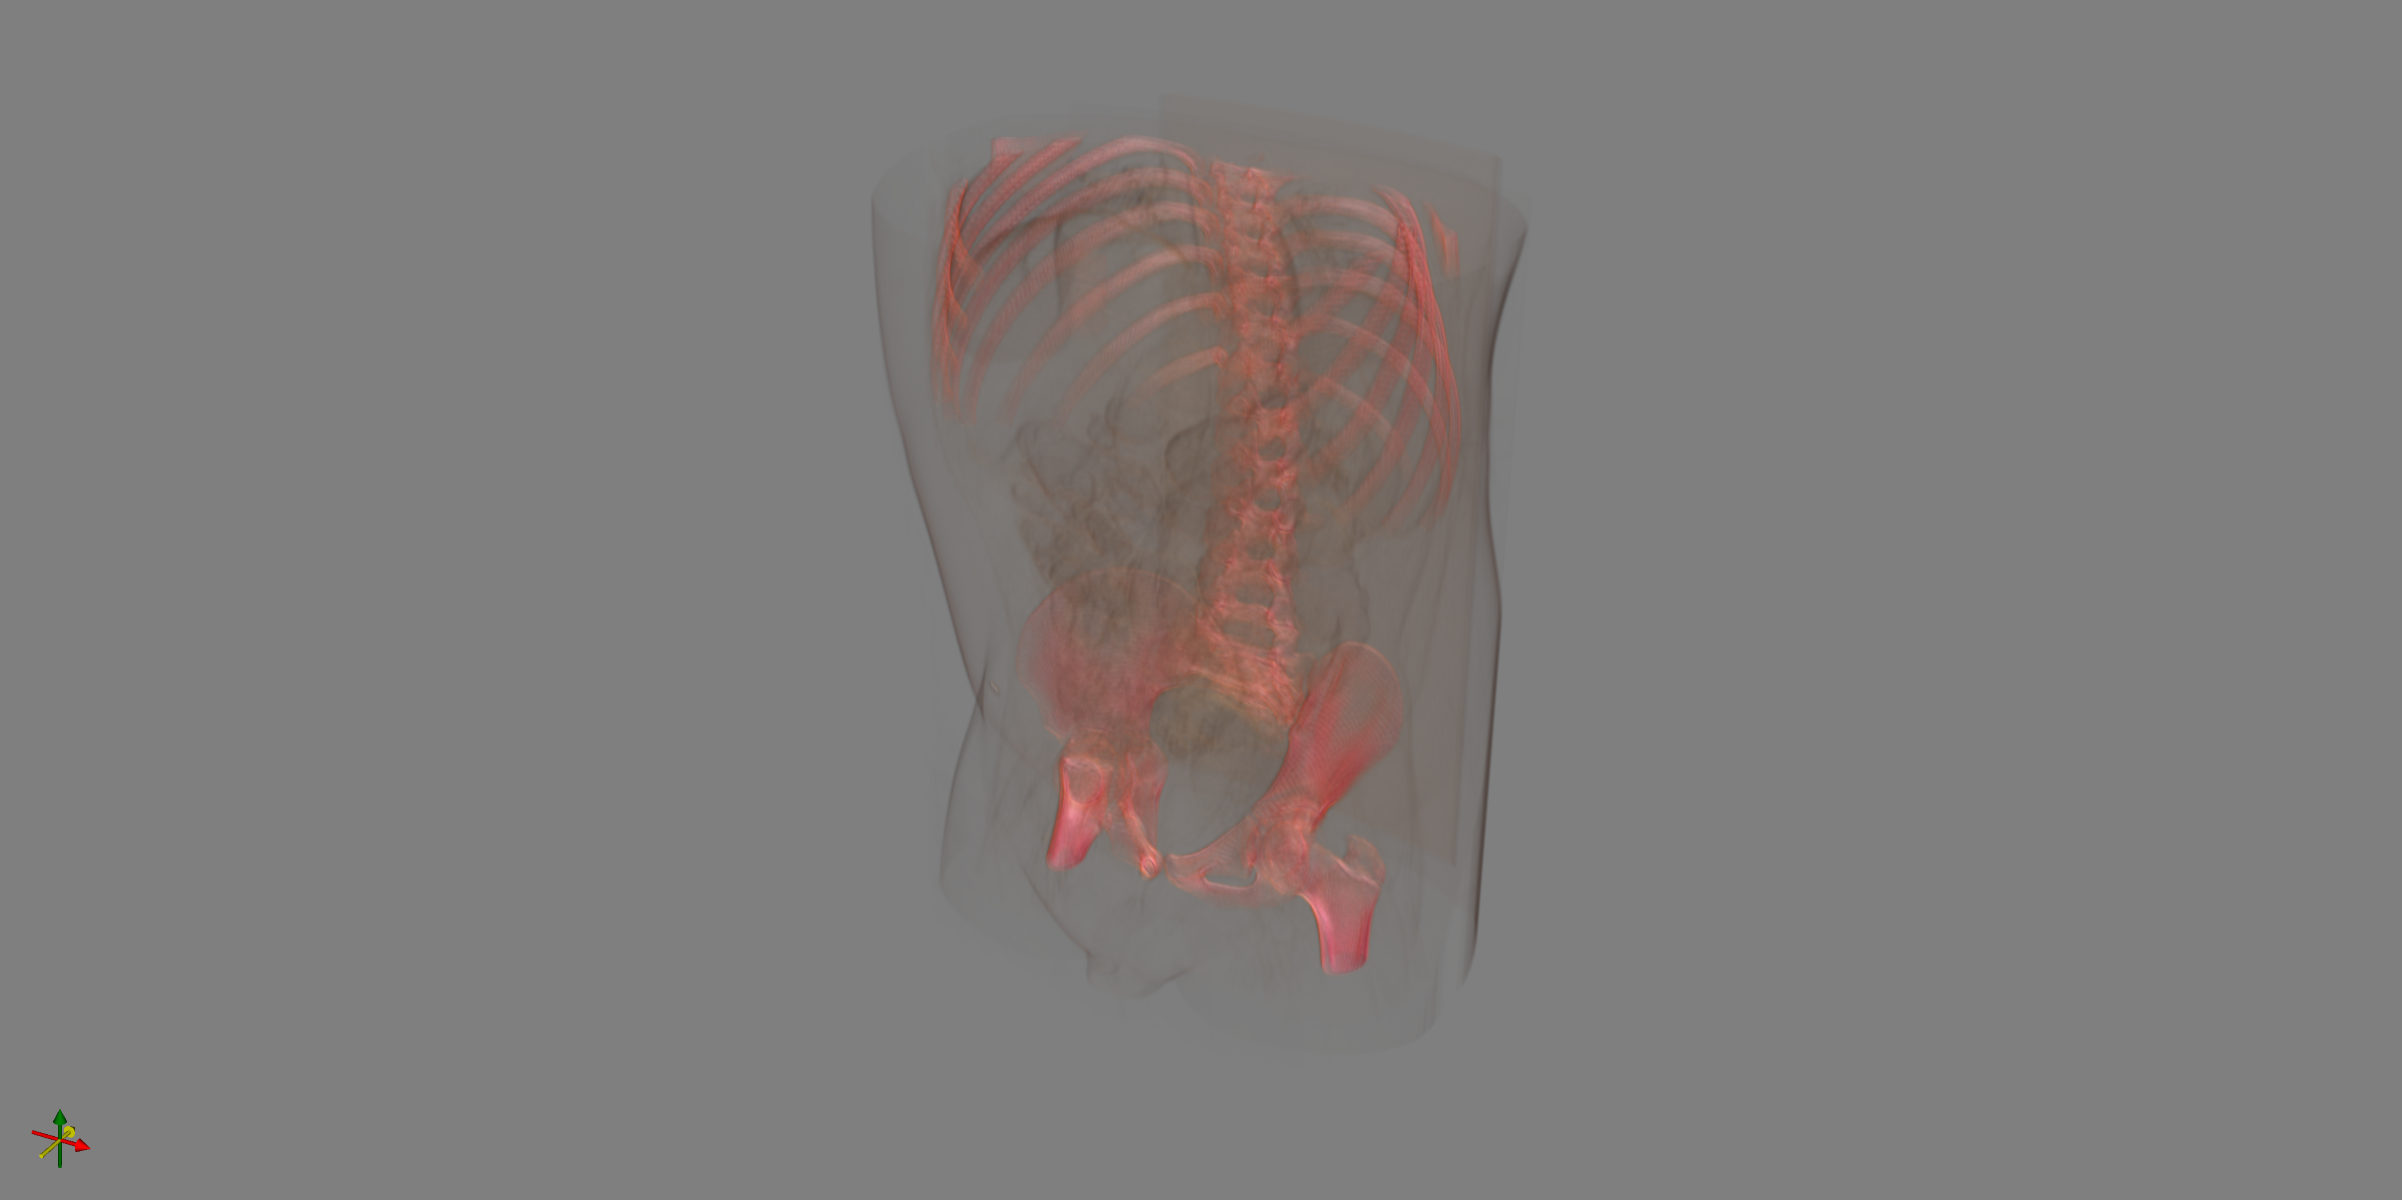
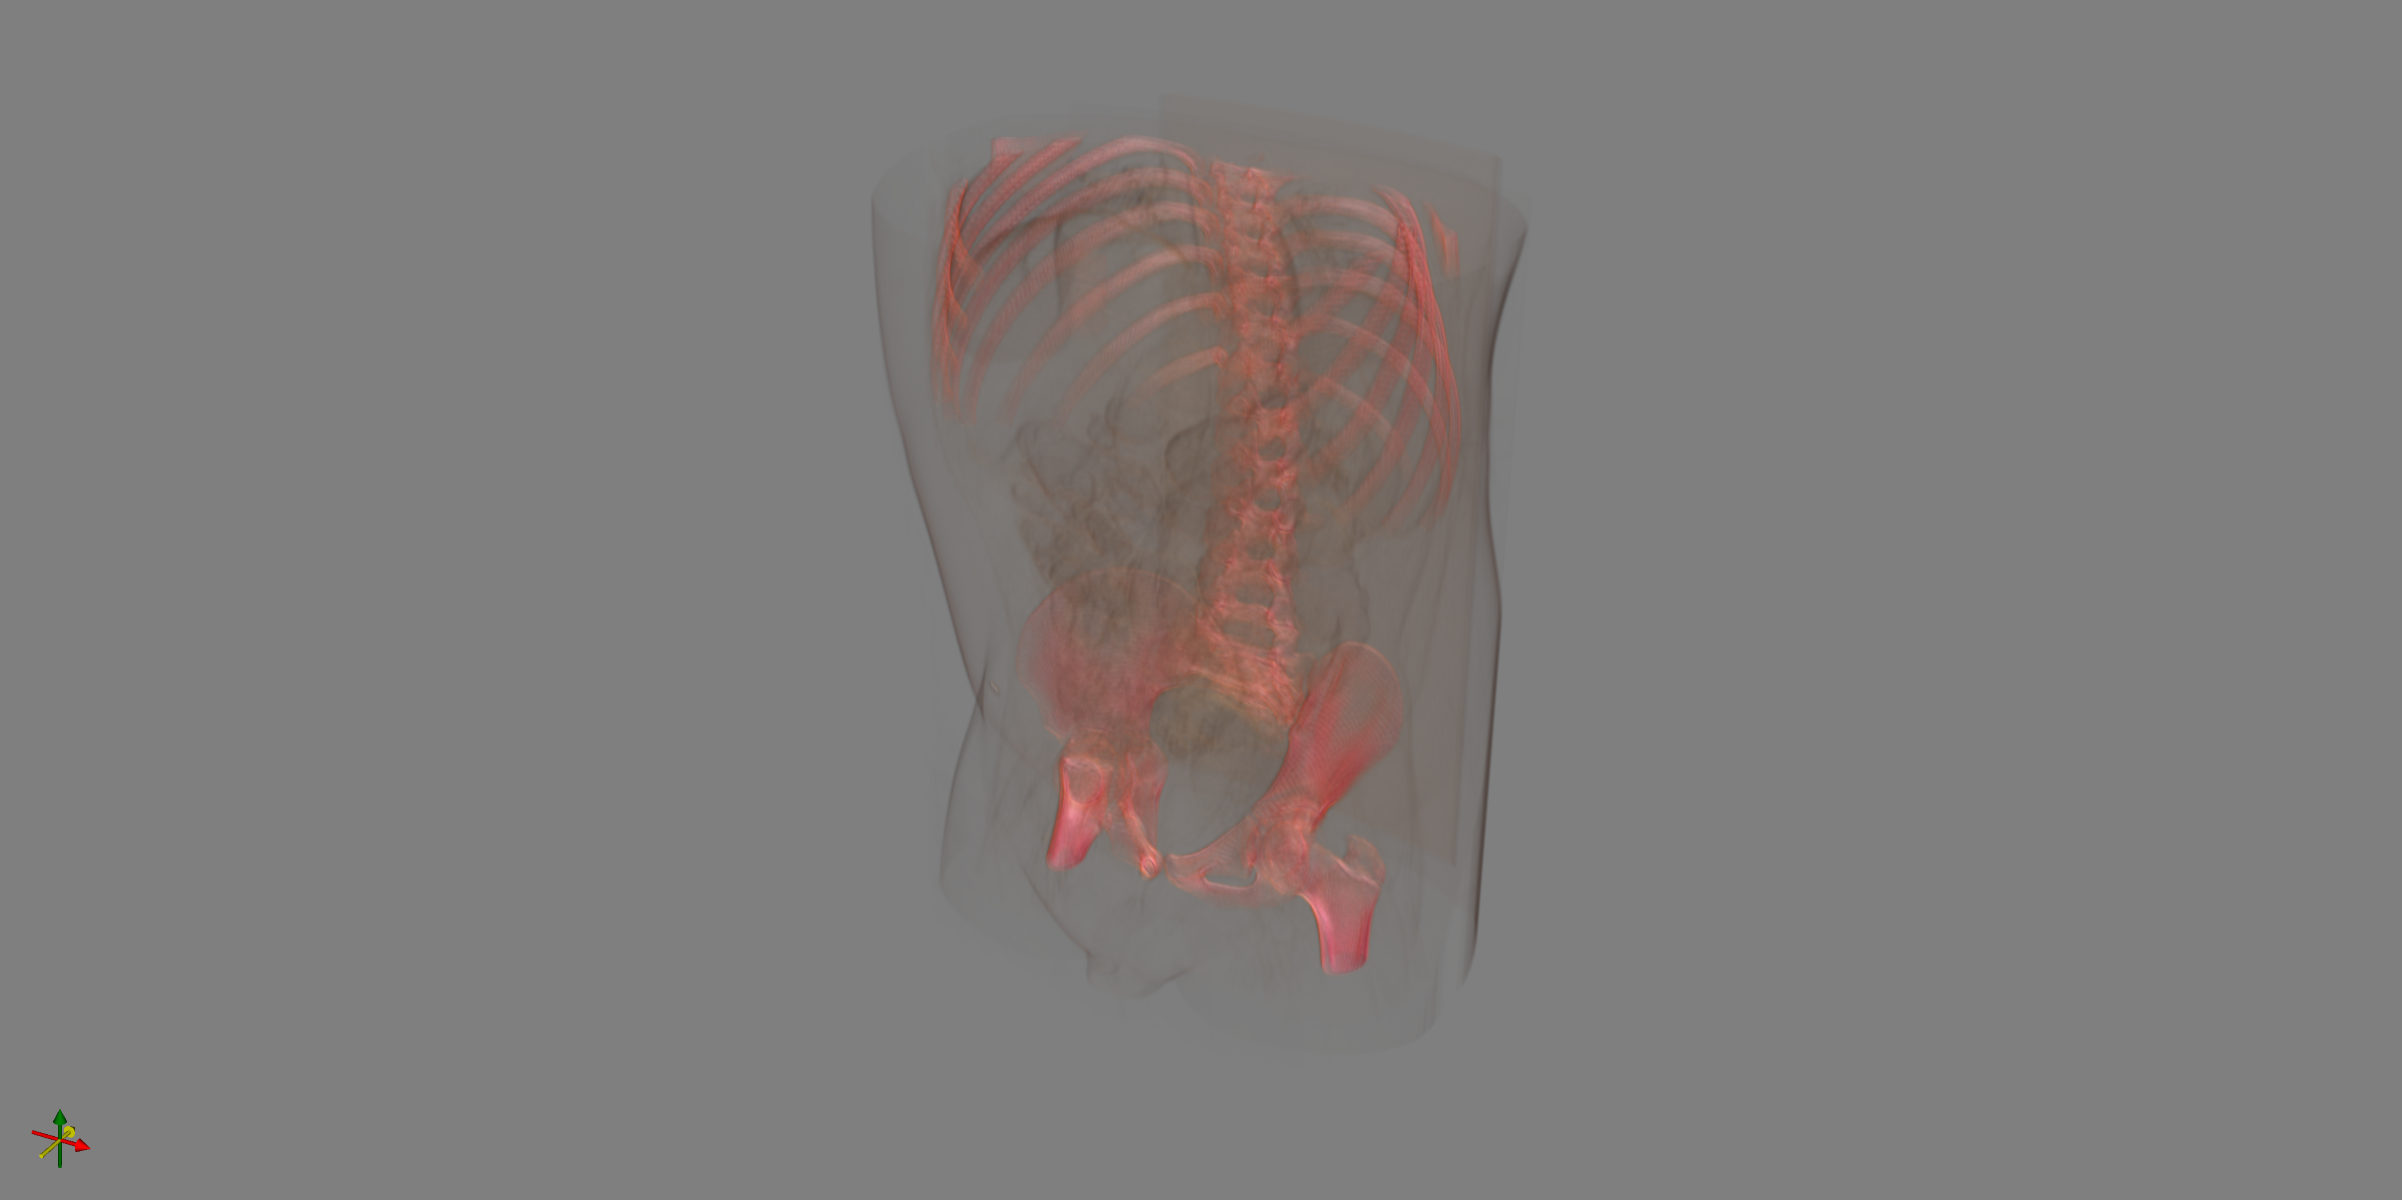

<IPython.core.display.Javascript object>

In [19]:
# View the image (or point clouds or polygons or numpy arrays or ...) using itkWidgets
#    Note after the load completes, it takes ~20 seconds for the data to appear in Colab and Sagemaker.  It is nearly instantaneous on local jupyter notebook/lab.
#    Also, the display is a multi-resolution display, so first coarse (and dim) versions of the data will be loaded, and then a final high-resolution version - due to data transfer limitations on Colab and Sagemaker.
# We also add the bones_labelmap as an overlay

# If an interactive 3D image doesn't appear, please re-load the webpage.  This happens when first installing the "ImJoy" module that is used
#   to insert the visualization into a cell.   If ImJoy is running correctly, the ImJoy icon (blue smiley face) should appear in the menu bar.

viewer = view(image=dicom_image, label_image=bones_labelmap)

# You can control many aspects of the visualization via GUI or programmatically.  Here we open the GUI control panel
viewer.set_ui_collapsed(False)

In [15]:
# Here we setup a view using a different colormap
viewer.set_view_mode('Volume')
viewer.set_image_color_map("Black-Body Radiation")
viewer.set_image_color_range([100,600])
viewer.set_image_gradient_opacity(0.1)
viewer.set_label_image_blend(0.3)
viewer.set_image_volume_sample_distance(0.05)

In [16]:
# You can also simply view the data as 2D slices
viewer.set_image_color_map("Grayscale")
viewer.set_image_color_range([-500,300])
viewer.set_label_image_blend(0.5)
viewer.set_view_mode('ZPlane')
viewer.set_z_slice(-146)


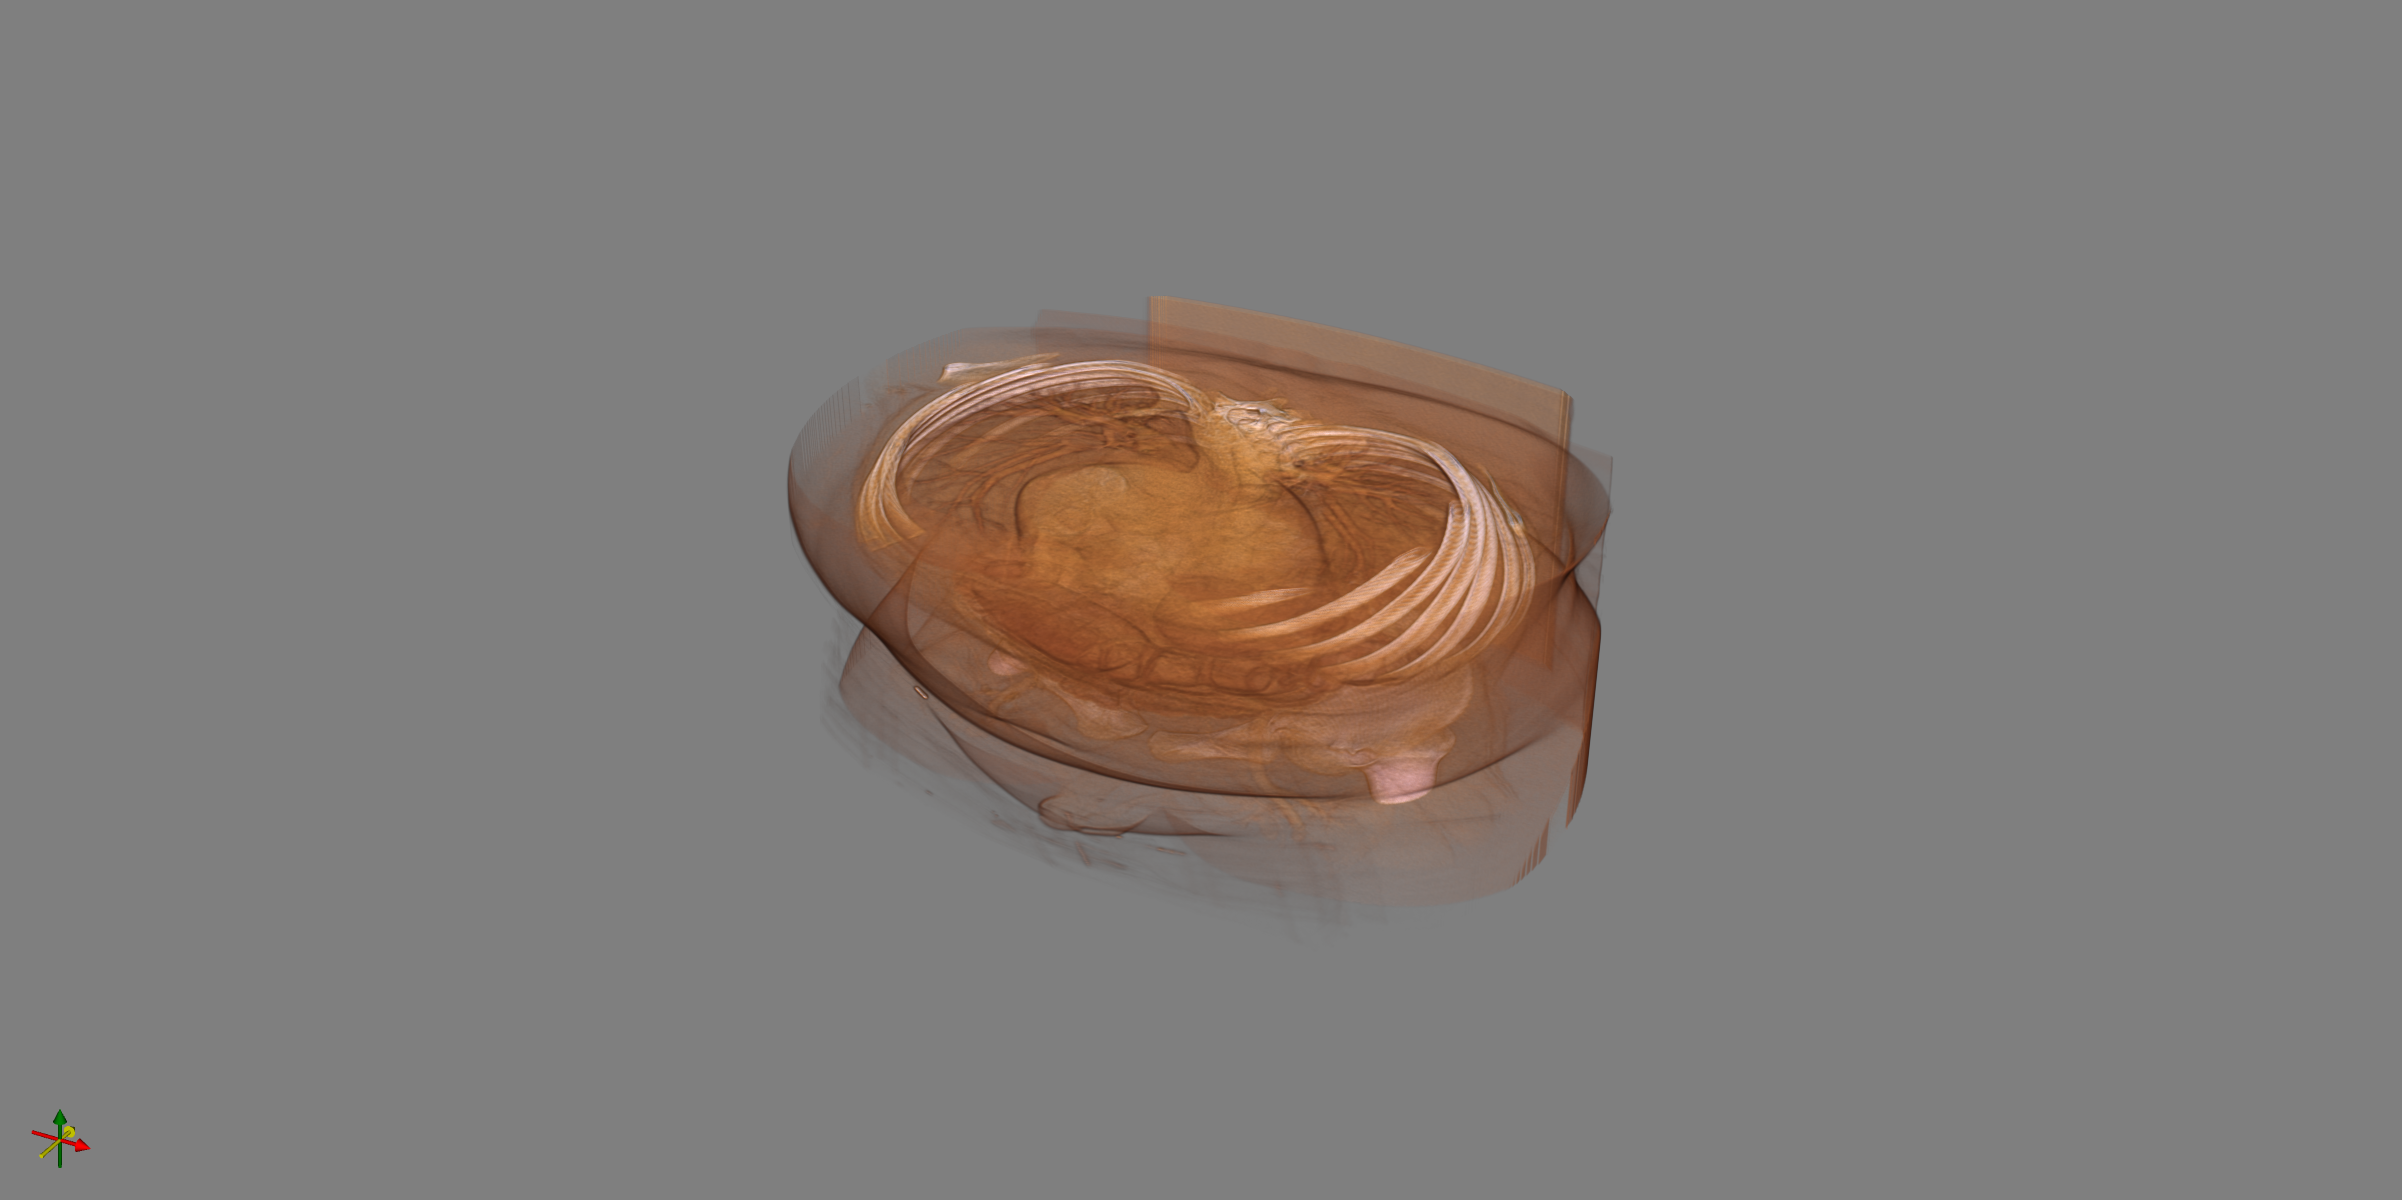
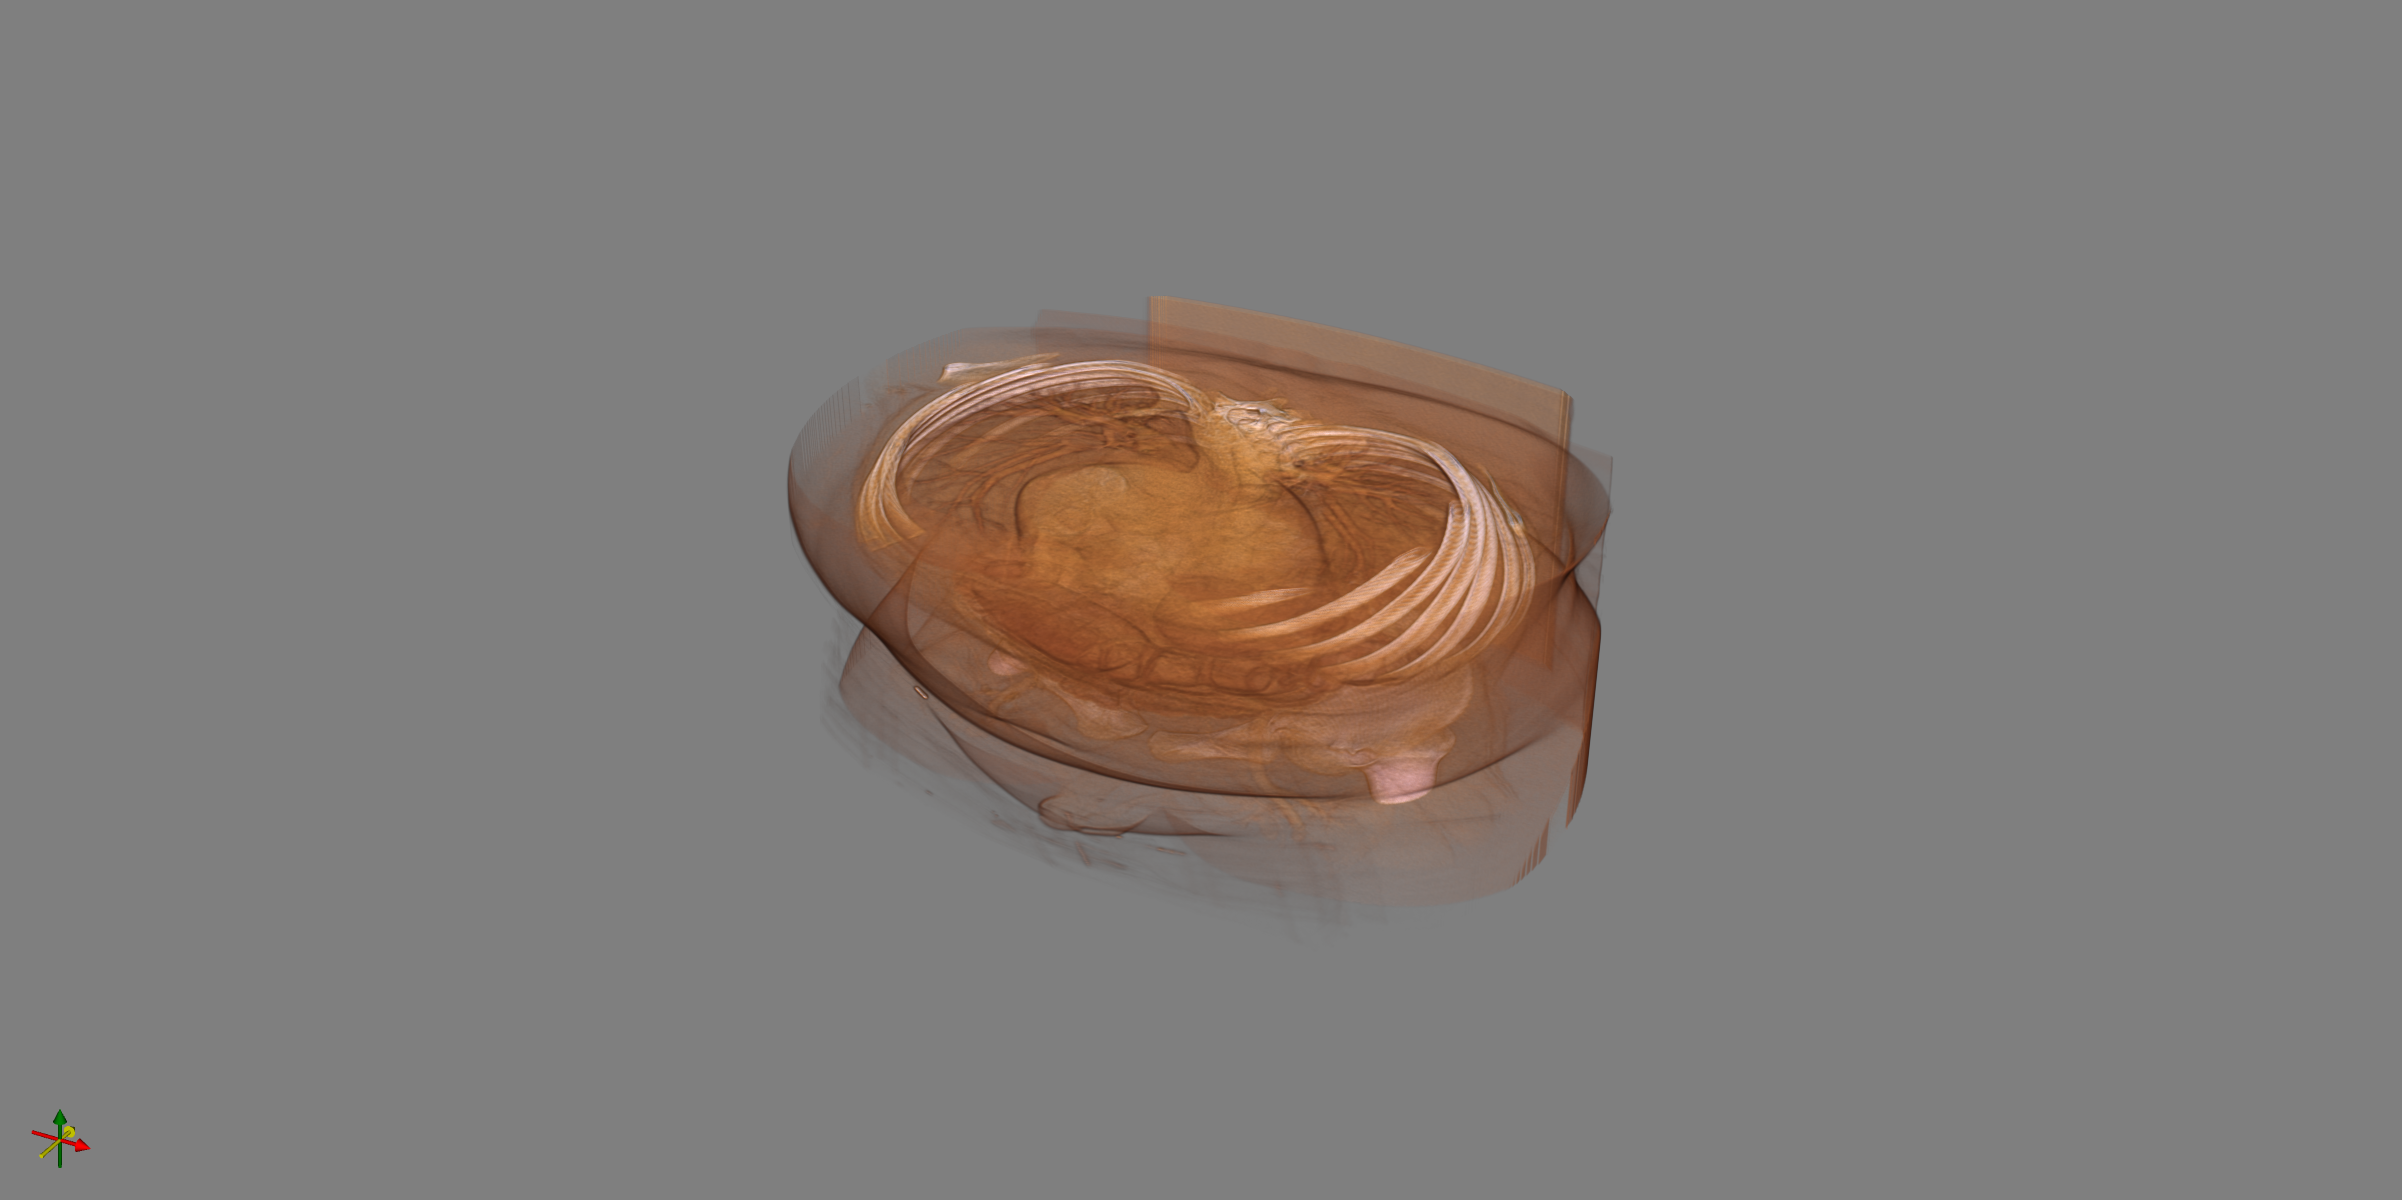

<IPython.core.display.Javascript object>

In [17]:
# We can also use itkWidgets to visualize Numpy arrays, which is useful for MONAI and other libraries,
#   but since numpy arrays don't maintain voxel spacing information, the visualization will look wonky, 
#   and subsequent computations could be erroneous...
dicom_array = itk.GetArrayFromImage(dicom_image)
view(dicom_array)

# Acknowledgements
TCIA is funded by the [Cancer Imaging Program (CIP)](https://imaging.cancer.gov/), a part of the United States [National Cancer Institute (NCI)](https://www.cancer.gov/), and is managed by the [Frederick National Laboratory for Cancer Research (FNLCR)](https://frederick.cancer.gov/).

This notebook was created by [Justin Kirby](https://www.linkedin.com/in/justinkirby82/), [Brianna Major (Kitware)](https://www.linkedin.com/in/brianna-major/), [Matt McCormick (Kitware)](https://www.linkedin.com/in/drmatthewmccormick/) and [Stephen Aylward (Kitware)](https://www.linkedin.com/in/stephenaylward/).  If you leverage this notebook or any TCIA datasets in your work please be sure to comply with the [TCIA Data Usage Policy](https://wiki.cancerimagingarchive.net/x/c4hF). In particular, make sure to cite the DOI(s) for the specific TCIA datasets you used in addition to the following paper!

## TCIA Citation

Clark, K., Vendt, B., Smith, K., Freymann, J., Kirby, J., Koppel, P., Moore, S., Phillips, S., Maffitt, D., Pringle, M., Tarbox, L., & Prior, F. (2013). The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository. Journal of Digital Imaging, 26(6), 1045–1057. https://doi.org/10.1007/s10278-013-9622-7